In [1]:
import numpy as np
import pandas as pd
import sklearn.neighbors

# Baseline model

$ p(\mathcal{S}, \mathcal{R} | \mathcal{C}, \mathcal{A}) =
p(\mathcal{S}|\mathcal{C}\mathcal{A})p(\mathcal{R}|\mathcal{C}\mathcal{A})$  

**Probability over sizes**  
$p(s|c_j) = \frac{1}{n_jh_j}\sum_{i=1}^{n_j} \phi(\frac{s-s_i}{h_j})
= \frac{1}{n_j}\sum_{i=1}^{n_j} \frac{1}{h_j\sqrt{2\pi}}e^{(\frac{s-s_i}{h_j})^2}$  
$= \frac{1}{n_j}\sum_{i=1}^{n_j} \mathcal{N}(s | s_i, h_j^2)$  
$= \frac{1}{n_jh_j\sqrt{2\pi}}\sum_{i=1}^{n_j} e^{(\frac{s-s_i}{h_j})^2}$   $

Where:  
$\phi$ - normal density function  
$h_j$ - bandwidth parameter for specific customer, for now we are using 1 for all customers. 

**Probablity over return status**  
$p(\mathcal{R}|\mathcal{C}\mathcal{A}) = p(\mathcal{R}|\mathcal{A})$  
$p(r|a_i) = \frac{n_{i, r} + 1}{n_i + 3}$   
Article $a_i$ was ordered $n_i$ times and got return status $r$ $n_{i, r}$ times.  

------------------

**NOTES:**  
We could add parameter like so:  
$p(r|a_i) = \frac{n_{i, r} + 
\rho}{n_i + 3\rho}$   


## Model code

In [67]:
class BaselineModel:
    def __init__(self):
        self.default_bandwidth = 1
        pass

    ############
    # Training #
    ############

    def _compute_default_values_over_return_status(self, df, return_status_column):
        default_values_df = df.value_counts(return_status_column)
        self.default_values = default_values_df.div(default_values_df.sum())
        self.default_values['predicted_return_status'] = self.default_values.idxmax()

    def _compute_number_of_sales_per_article_and_return(self, df, return_status_column):
        dummies = pd.get_dummies(df[return_status_column])
        df_encoded = pd.concat([df, dummies], axis=1)
        sales_by_fit  = df_encoded[["item_id"]+list(dummies.columns)].groupby(["item_id"]).sum() + 1
        self.sales_probability_by_fit = sales_by_fit.div(sales_by_fit.sum(axis=1), axis=0)
        self.sales_probability_by_fit['predicted_return_status'] = self.sales_probability_by_fit.idxmax(axis=1)
        self.sales_probability_by_fit['predicted_return_status_prob'] = self.sales_probability_by_fit[dummies.columns].max(axis=1)
        self.sales_probability_by_fit['predicted_return_status_logprob'] = np.log(self.sales_probability_by_fit['predicted_return_status_prob'])


    def train_model_return_status(self, df, return_status_column ='result'):
        self._compute_default_values_over_return_status(df, return_status_column)
        self._compute_number_of_sales_per_article_and_return(df, return_status_column)
    
    def _create_size_density(self, df, size_column = 'size'): # takes about 20s
        self.size_density_per_user = df.groupby("user_id")[size_column].agg(
            lambda X:
            sklearn.neighbors.KernelDensity(kernel='gaussian', bandwidth=self.default_bandwidth)
            .fit(X.values.reshape(-1, 1))
        ).rename("size_density")

    def _create_default_size_density(self, df, size_column ='size'):
        self.default_size_density = (sklearn.neighbors.KernelDensity(kernel='gaussian', bandwidth=self.default_bandwidth)
                                    .fit(df[size_column].values.reshape(-1,1)))

    def _compute_default_size_prediction(self):
        sizes = np.arange(0,58).reshape(-1, 1)
        self.default_size_scores = self.default_size_density.score_samples(sizes)
        self.default_best_size = np.argmax(self.default_size_scores)
        self.default_best_size_log_prob = self.default_size_scores.max()


    def _compute_size_likelihoods_per_user(self): # takes about 40s
        sizes = np.arange(0, 58).reshape(-1, 1)
        self.size_scores = self.size_density_per_user.apply(
            lambda kd:
            kd.score_samples(sizes)
        )
    def _find_best_size_per_user(self):
        self.best_size = pd.DataFrame({#"user_id": self.size_scores.index, 
                                       "predicted_size": self.size_scores.apply(np.argmax).values, 
                                       "predicted_size_logprob": self.size_scores.apply(max)}).reset_index()

    def train_model_size(self, df, size_column = 'size'): # takes ~ 1min
        # perhaps use skleran.neighbors.KernelDensity
        # they want to use MISE to select bandwidth
        # as a start we can use bandwidth = 1 ?
        self._create_default_size_density(df, size_column)
        self._create_size_density(df, size_column)
        self._compute_size_likelihoods_per_user()
        self._compute_default_size_prediction()
        self._find_best_size_per_user()

    def train_model(self, df, return_status_column = 'result', size_column='size'):
        self.train_model_return_status(df, return_status_column)
        self.train_model_size(df, size_column)

    ###############
    # Predictions #
    ###############

    def predict_return_status(self, df):
        prediction = df.merge(self.sales_probability_by_fit, how='left', on='item_id')
        prediction = prediction.fillna(self.default_values)
        return prediction

    def predict_size(self, df):
        prediction = df.merge(self.best_size, how='left', on='user_id')
        prediction["predicted_size"] = prediction["predicted_size"].fillna(self.default_best_size)
        prediction["predicted_size_logprob"] = prediction["predicted_size_logprob"].fillna(self.default_best_size_log_prob)
        prediction["predicted_size_prob"] = np.exp(prediction["predicted_size_logprob"])
        return prediction

    def _return_status_prob_from_prediction(self, predictions, return_status_column = 'result'):
        prob = predictions.apply(lambda row: row[row[return_status_column]], axis=1)
        return prob

    def return_status_prob(self, df, return_status_column = 'result'):
        predictions = self.predict_return_status(df)
        return self._return_status_prob_from_prediction(self, predictions, return_status_column)

    def return_status_logprob(self, df, return_status_column = 'result'):
        prob = self.return_status_prob(self, df, return_status_column)
        return np.log(prob)

    def size_logprob(self, df, size_column = 'size'):
        logprobs = df.merge(self.size_density_per_user, how='left', on='user_id')
        logprobs['size_density'] = logprobs['size_density'].fillna(self.default_size_density)
        #self.logprobs_size = logprobs
        logprobs = logprobs.apply(
            lambda row: 
            row['size_density'].score_samples(np.ones((1,1))*row[size_column]), axis=1).apply(lambda row: row[0])
        return logprobs

    def size_prob(self, df):
        logprobs = self.size_logprob(df)
        return np.exp(logprobs)
    
    def full_predict_and_logprob_return_status(self, df, return_status_column='result'):
        prediction = self.predict_return_status(df)
        prediction['return_status_prob'] = self._return_status_prob_from_prediction(prediction, return_status_column)
        prediction['return_status_logprob'] = np.log(prediction['return_status_prob'])
        return prediction

    def full_predict_and_logprob_size(self, df, size_column='size'): # takes ~ 1min
        prediction = self.predict_size(df)
        prediction["size_logprob"] = self.size_logprob(df, size_column)
        prediction["size_prob"] = np.exp(prediction["size_logprob"])
        #print(prediction.columns)
        return prediction

    def full_predict_and_logprob(self, df, size_column = 'size', return_status_column ='result'):
        size_prediction = self.full_predict_and_logprob_size(df, size_column)
        print("Predicted_size")
        full_prediction = self.full_predict_and_logprob_return_status(size_prediction, return_status_column)
        print("Predicted return status")
        full_prediction["full_predicted_prob"] = full_prediction["predicted_return_status_prob"] * full_prediction["predicted_size_prob"]
        full_prediction["full_predicted_logprob"] = full_prediction["predicted_return_status_logprob"] + full_prediction["predicted_size_logprob"]
        full_prediction["full_prob"] = full_prediction["return_status_prob"] * full_prediction["size_prob"]
        full_prediction["full_logprob"] = full_prediction["return_status_logprob"] + full_prediction["size_logprob"]
        return full_prediction





        
        # 2 ideas for functions
        # 1st: Write a function that for every costumer, size in df finds density in point size - do it every time a function is called
        # 2nd: Write a function that for each costumer selects best size (check all available sizes 0-58 and select one with max probablity) - do it once and safe lookup table
        
        
        


In [40]:
from data_preparation import get_processed_renttherunway_data, get_test_runttherunway_data, get_train_runttherunway_data

In [41]:
df = get_processed_renttherunway_data()

In [42]:
bs = BaselineModel()

In [43]:
bs.train_model(df)

In [46]:
df

,result_original,user_id_original,item_id_original,size,review_date,category,user_id,item_id,result
0,fit,420272,2260466,14,"April 20, 2016",romper,44334,4396,0
1,fit,273551,153475,12,"June 18, 2013",gown,28835,65,0
2,fit,360448,1063761,4,"December 14, 2015",sheath,37976,1945,0
3,fit,909926,126335,8,"February 12, 2014",dress,96080,7,0
4,fit,151944,616682,12,"September 26, 2016",gown,15959,1032,0
...,...,...,...,...,...,...,...,...,...
192539,fit,66386,2252812,8,"May 18, 2016",jumpsuit,7026,4382,0
192540,fit,118398,682043,4,"September 30, 2016",dress,12494,1164,0
192541,fit,47002,683251,8,"March 4, 2016",dress,5019,1166,0
192542,fit,961120,126335,16,"November 25, 2015",dress,101534,7,0


In [47]:
full_result = bs.full_predict_and_logprob(df)

Predicted_size
Predicted return status


In [49]:
full_result.to_csv("results/baseline_full_results_trained_on_full.csv", index=False)

In [48]:
full_result

,result_original,user_id_original,item_id_original,size,review_date,category,user_id,item_id,result,predicted_size,...,2,predicted_return_status,predicted_return_status_prob,predicted_return_status_logprob,return_status_prob,return_status_logprob,full_predicted_prob,full_predicted_logprob,full_prob,full_logprob
0,fit,420272,2260466,14,"April 20, 2016",romper,44334,4396,0,14,...,0.322581,0,0.645161,-0.438255,0.645161,-0.438255,0.177394,-1.729385,0.177394,-1.729385
1,fit,273551,153475,12,"June 18, 2013",gown,28835,65,0,12,...,0.080460,0,0.783525,-0.243952,0.783525,-0.243952,0.312581,-1.162891,0.312581,-1.162891
2,fit,360448,1063761,4,"December 14, 2015",sheath,37976,1945,0,4,...,0.250000,0,0.714286,-0.336472,0.714286,-0.336472,0.284959,-1.255411,0.284959,-1.255411
3,fit,909926,126335,8,"February 12, 2014",dress,96080,7,0,8,...,0.047683,0,0.748217,-0.290062,0.748217,-0.290062,0.298496,-1.209000,0.298496,-1.209000
4,fit,151944,616682,12,"September 26, 2016",gown,15959,1032,0,16,...,0.034188,0,0.931624,-0.070826,0.931624,-0.070826,0.265510,-1.326103,0.053184,-2.933999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,66386,2252812,8,"May 18, 2016",jumpsuit,7026,4382,0,8,...,0.021277,0,0.893617,-0.112478,0.893617,-0.112478,0.254678,-1.367755,0.254678,-1.367755
192540,fit,118398,682043,4,"September 30, 2016",dress,12494,1164,0,4,...,0.183099,0,0.746479,-0.292388,0.746479,-0.292388,0.199637,-1.611252,0.199637,-1.611252
192541,fit,47002,683251,8,"March 4, 2016",dress,5019,1166,0,8,...,0.255639,0,0.721805,-0.326001,0.721805,-0.326001,0.203995,-1.589662,0.203995,-1.589662
192542,fit,961120,126335,16,"November 25, 2015",dress,101534,7,0,16,...,0.047683,0,0.748217,-0.290062,0.748217,-0.290062,0.298496,-1.209000,0.298496,-1.209000


In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def create_confusion_matrix(result_df,target_column, prediction_column):
    labels = result_df[target_column].unique()
    confusion_m = pd.DataFrame(confusion_matrix(result_df[target_column], result_df[prediction_column], labels=labels), 
                                index=['true_'+str(l) for l in labels], 
                                columns=['predicted_'+str(l) for l in labels])
    return confusion_m
def show_confusion_matrix(results,target_column, prediction_column):
    confusion_m = create_confusion_matrix(results,target_column, prediction_column)
    sns.heatmap(confusion_m, annot=True, fmt='d')

------ Return status results ------
Mean target probability:  0.627207998160124
Mean target log probability:  -0.6118634657298393


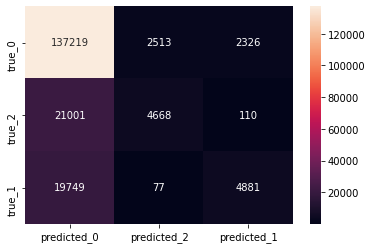

In [79]:
print("------ Return status results ------")
print("Mean target probability: ", full_result["return_status_prob"].mean())
print("Mean target log probability: ", full_result["return_status_logprob"].mean())
show_confusion_matrix(full_result, "result", "predicted_return_status")

------ Size results ------
Mean target probability:  0.29663856459606497
Mean target log probability:  -1.3219672449644497


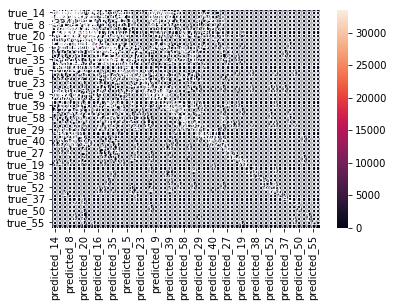

In [80]:
print("------ Size results ------")
print("Mean target probability: ", full_result["size_prob"].mean())
print("Mean target log probability: ", full_result["size_logprob"].mean())
show_confusion_matrix(full_result, "size", "predicted_size")

## Test on split dataset

In [68]:
bs = BaselineModel()
train = get_train_runttherunway_data()
test = get_test_runttherunway_data()
bs.train_model(train)

In [85]:
train_result = bs.full_predict_and_logprob(train)


In [55]:
#train_result.to_csv("results/baseline_results_train_trained_on_train.csv", index=False)
train_result = pd.read_csv("results/baseline_results_train_trained_on_train.csv")

In [58]:
bs.default_size_density.score_samples

<bound method KernelDensity.score_samples of KernelDensity(bandwidth=1)>

In [69]:
test_result = bs.full_predict_and_logprob(test)

Predicted_size
Predicted return status


In [70]:
test_result.to_csv("results/baseline_results_test_trained_on_train.csv", index=False)

TRAIN DATA
------ Return status results ------
Mean target probability:  0.6265592026856295
Mean target log probability:  -0.6108522590414879
------ Size results ------
Mean target probability:  0.3006320347598758
Mean target log probability:  -1.3047251771957795


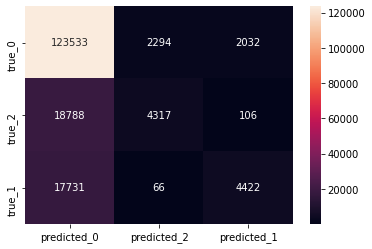

In [89]:
print("TRAIN DATA")
print("------ Return status results ------")
print("Mean target probability: ", train_result["return_status_prob"].mean())
print("Mean target log probability: ", train_result["return_status_logprob"].mean())
show_confusion_matrix(train_result, "result", "predicted_return_status")
print("------ Size results ------")
print("Mean target probability: ", train_result["size_prob"].mean())
print("Mean target log probability: ", train_result["size_logprob"].mean())

TEST DATA
------ Return status results ------
Mean target probability:  0.6139778424794279
Mean target log probability:  -0.6540144773172976
------ Size results ------
Mean target probability:  0.12459749822611516
Mean target log probability:  -4.4633190141285155


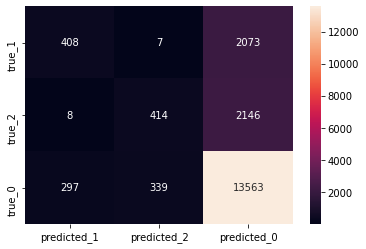

In [90]:
print("TEST DATA")
print("------ Return status results ------")
print("Mean target probability: ", test_result["return_status_prob"].mean())
print("Mean target log probability: ", test_result["return_status_logprob"].mean())
show_confusion_matrix(test_result, "result", "predicted_return_status")
print("------ Size results ------")
print("Mean target probability: ", test_result["size_prob"].mean())
print("Mean target log probability: ", test_result["size_logprob"].mean())